In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress

In [2]:
input_dir = r'Figure_Data'
output_dir = r'Figure_Export'

In [3]:
# Formatted in the event multiple DBTL files are used
filenames = [f'DBTL{0}.csv']
input_paths = [os.path.join(input_dir, filename) for filename in filenames]

# Load CSVs and concatenate multiple files if necessary
dataframes = [pd.read_csv(input_path) for input_path in input_paths]
proteomics_df = pd.concat(dataframes, ignore_index=True)

isoprenol_df = pd.read_csv('Figure_Data/250317_All_Data.csv')
proteomics_df['Line Name'] = proteomics_df['Sample'] + '-' + proteomics_df['Replicate'].astype(str)

In [4]:
isoprenol_df = isoprenol_df[ (isoprenol_df['cycle'] == 0)]

Merged DataFrame shape: (720948, 17)
Filtered DataFrame shape: (675412, 17)
Unique proteins in filtered DataFrame: 2049
['Neo' 'Tryp_pig' 'Krt1' ... 'Pp_0129' 'Pp_0122' 'Pp_0103']
Pivot table shape: (375, 2049)


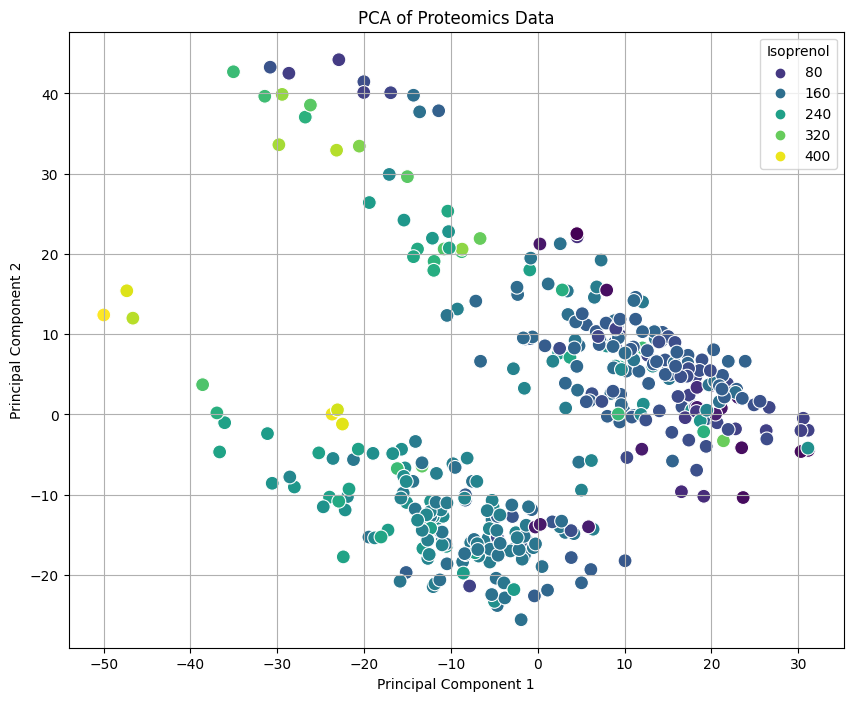

In [5]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrames are already defined: proteomics_df and isoprenol_df

# Remove duplicate entries in "Line Name"
proteomics_df = proteomics_df.drop_duplicates(subset=['Line Name', 'Protein'])
isoprenol_df = isoprenol_df.drop_duplicates(subset='Line Name')

# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(proteomics_df, isoprenol_df, on='Line Name')

# Inspect merged data
print(f"Merged DataFrame shape: {merged_df.shape}")

# Filter out rows where the relevant columns are zero or below the specified thresholds
filtered_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] > 0) &
                        (merged_df['isoprenol'] > 0) &
                        (merged_df['%_of protein_abundance_Top3-method'] >= 0.0001) &  # Lower threshold
                        (merged_df['isoprenol'] >= 1)]  # Lower threshold

# Inspect filtered data
print(f"Filtered DataFrame shape: {filtered_df.shape}")

# Check unique proteins in the filtered DataFrame
unique_proteins = filtered_df['Protein'].unique()
print(f"Unique proteins in filtered DataFrame: {len(unique_proteins)}")
print(unique_proteins)

# Pivot the DataFrame to have proteins as columns and samples as rows
pivot_df = filtered_df.pivot(index='Line Name', columns='Protein', values='%_of protein_abundance_Top3-method')

# Fill missing values with 0 or another appropriate value
pivot_df = pivot_df.fillna(0)

# Check the dimensions of the pivot table
print(f"Pivot table shape: {pivot_df.shape}")

# Ensure there are more than 1 sample and 1 feature
if pivot_df.shape[0] <= 1 or pivot_df.shape[1] <= 1:
    raise ValueError("The pivot table must have more than 1 sample and more than 1 feature for PCA.")

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Perform PCA
n_components = min(2, pivot_df.shape[0], pivot_df.shape[1])  # Adjust n_components based on the data dimensions
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['Line Name'] = pivot_df.index

# Merge the PCA results with the isoprenol data for visualization
final_df = pd.merge(pca_df, isoprenol_df[['Line Name', 'isoprenol']], on='Line Name')

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='isoprenol', palette='viridis', s=100)
plt.title('PCA of Proteomics Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Isoprenol')
plt.grid(True)
plt.show()

              PC1       PC2
Protein                    
Aacc1    0.029749 -0.040854
Aapj    -0.004586  0.037678
Aapm     0.002218  0.022768
Aapp    -0.015355  0.031868
Aapq    -0.019600  0.028839
...           ...       ...
Yidc     0.013934 -0.014804
Zape    -0.009850 -0.024057
Zipa    -0.035919 -0.014254
Zwf-1   -0.000273  0.020940
Zwf-3   -0.031768 -0.009649

[2049 rows x 2 columns]


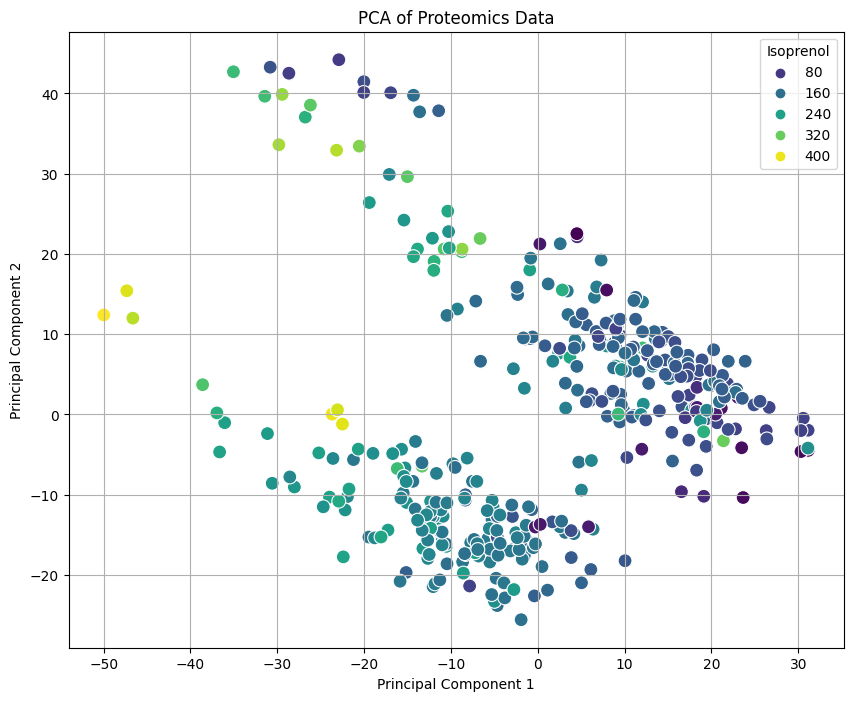

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrames are already defined: proteomics_df and isoprenol_df

# Remove duplicate entries in "Line Name"
proteomics_df = proteomics_df.drop_duplicates(subset=['Line Name', 'Protein'])
isoprenol_df = isoprenol_df.drop_duplicates(subset='Line Name')

# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(proteomics_df, isoprenol_df, on='Line Name')

# Filter out rows where the relevant columns are zero or below the specified thresholds
filtered_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] > 0) &
                        (merged_df['isoprenol'] > 0) &
                        (merged_df['%_of protein_abundance_Top3-method'] >= 0.0001) &  # Lower threshold
                        (merged_df['isoprenol'] >= 1)]  # Lower threshold

# Pivot the DataFrame to have proteins as columns and samples as rows
pivot_df = filtered_df.pivot(index='Line Name', columns='Protein', values='%_of protein_abundance_Top3-method')

# Fill missing values with 0 or another appropriate value
pivot_df = pivot_df.fillna(0)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Perform PCA
n_components = min(2, pivot_df.shape[0], pivot_df.shape[1])  # Adjust n_components based on the data dimensions
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['Line Name'] = pivot_df.index

# Extract loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=pivot_df.columns)

# Display loadings
print(loadings)

# Merge the PCA results with the isoprenol data for visualization
final_df = pd.merge(pca_df, isoprenol_df[['Line Name', 'isoprenol']], on='Line Name')

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='isoprenol', palette='viridis', s=100)
plt.title('PCA of Proteomics Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Isoprenol')
plt.grid(True)
plt.show()

loadings.to_csv('loadings.csv', index=True)

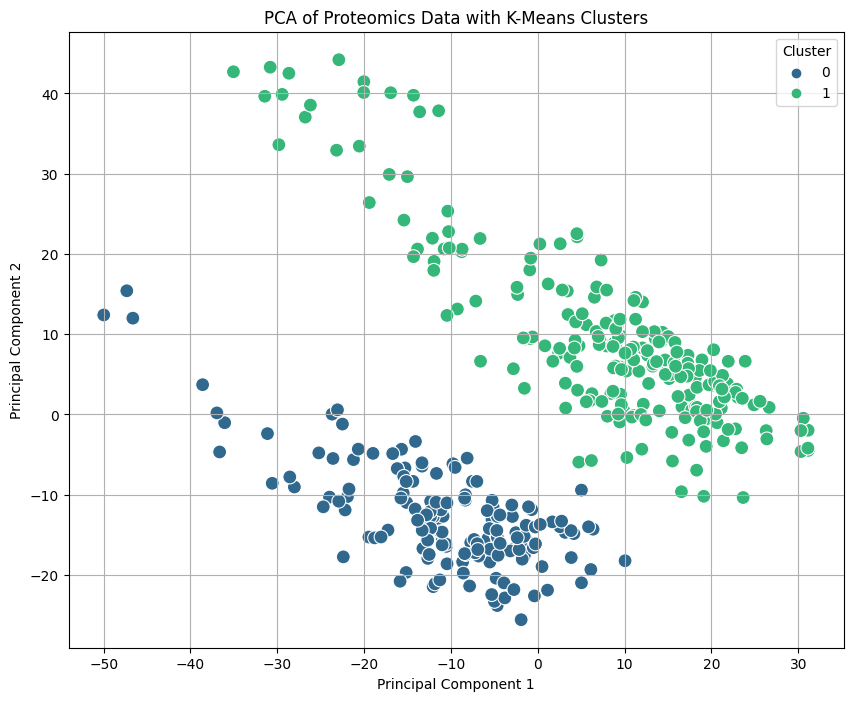

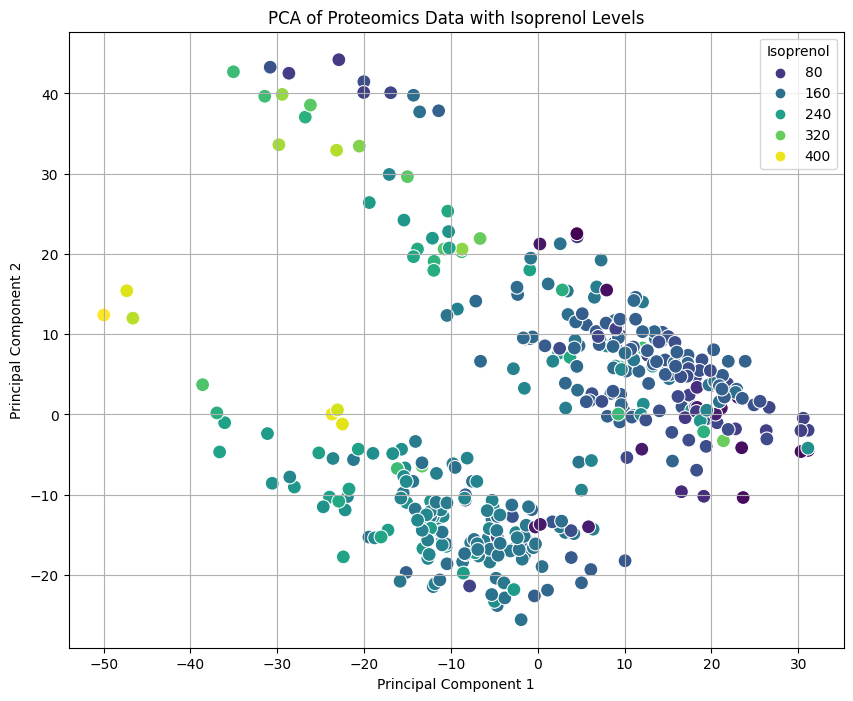

In [10]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrames are already defined: proteomics_df and isoprenol_df

# Remove duplicate entries in "Line Name"
proteomics_df = proteomics_df.drop_duplicates(subset=['Line Name', 'Protein'])
isoprenol_df = isoprenol_df.drop_duplicates(subset='Line Name')

# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(proteomics_df, isoprenol_df, on='Line Name')

# Filter out rows where the relevant columns are zero or below the specified thresholds
filtered_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] > 0) &
                        (merged_df['isoprenol'] > 0) &
                        (merged_df['%_of protein_abundance_Top3-method'] >= 0.0001) &  # Lower threshold
                        (merged_df['isoprenol'] >= 1)]  # Lower threshold

# Pivot the DataFrame to have proteins as columns and samples as rows
pivot_df = filtered_df.pivot(index='Line Name', columns='Protein', values='%_of protein_abundance_Top3-method')

# Fill missing values with 0 or another appropriate value
pivot_df = pivot_df.fillna(0)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Perform PCA
n_components = min(2, pivot_df.shape[0], pivot_df.shape[1])  # Adjust n_components based on the data dimensions
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['Line Name'] = pivot_df.index

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2)  # You can choose the number of clusters
cluster_labels = kmeans.fit_predict(principal_components)

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = cluster_labels

# Merge the PCA results with the isoprenol data for visualization
final_df = pd.merge(pca_df, isoprenol_df[['Line Name', 'isoprenol']], on='Line Name')

# Plot the PCA results with clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)
plt.title('PCA of Proteomics Data with K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Plot the PCA results with isoprenol levels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='isoprenol', palette='viridis', s=100)
plt.title('PCA of Proteomics Data with Isoprenol Levels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Isoprenol')
plt.grid(True)
plt.show()

Cluster 0: ['Control-R1', 'Control-R10', 'Control-R11', 'Control-R12', 'Control-R13', 'Control-R14', 'Control-R2', 'Control-R3', 'Control-R4', 'Control-R5', 'Control-R6', 'Control-R7', 'Control-R8', 'Control-R9', 'PP_0168-R1', 'PP_0168-R2', 'PP_0168-R3', 'PP_0338-R1', 'PP_0338-R2', 'PP_0338-R3', 'PP_0362-R1', 'PP_0362-R2', 'PP_0362-R3', 'PP_0368-R1', 'PP_0368-R2', 'PP_0368-R3', 'PP_0437-R1', 'PP_0437-R2', 'PP_0437-R3', 'PP_0528-R1', 'PP_0528-R2', 'PP_0528-R3', 'PP_0548-R1', 'PP_0548-R2', 'PP_0548-R3', 'PP_0582-R1', 'PP_0582-R2', 'PP_0582-R3', 'PP_0597-R1', 'PP_0597-R2', 'PP_0597-R3', 'PP_0774-R1', 'PP_0774-R2', 'PP_0774-R3', 'PP_0806-R1', 'PP_0806-R2', 'PP_0806-R3', 'PP_0999-R1', 'PP_1031-R1', 'PP_1157-R1', 'PP_1157-R2', 'PP_1157-R3', 'PP_1394-R1', 'PP_1394-R2', 'PP_1394-R3', 'PP_1444-R1', 'PP_1444-R2', 'PP_1444-R3', 'PP_1607_NT1-R1', 'PP_1607_NT1-R2', 'PP_1607_NT1-R3', 'PP_1664-R1', 'PP_1770-R1', 'PP_2136-R1', 'PP_2136-R2', 'PP_2136-R3', 'PP_2137-R1', 'PP_2137-R2', 'PP_2137-R3', 'PP_2

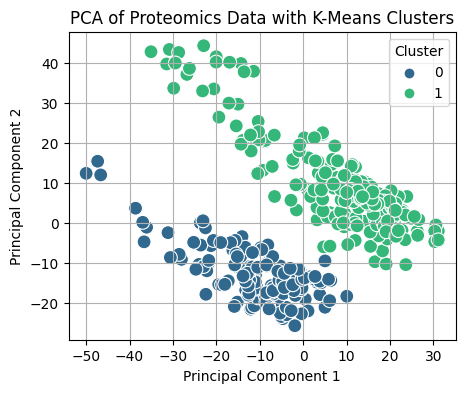

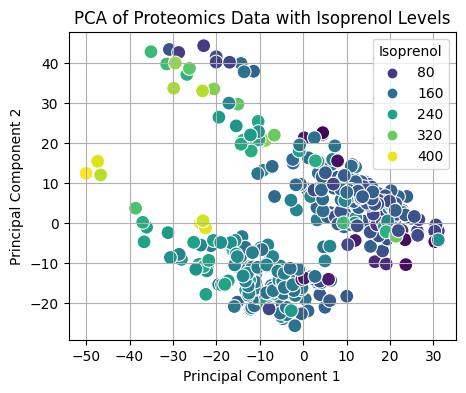

In [45]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrames are already defined: proteomics_df and isoprenol_df

# Remove duplicate entries in "Line Name"
proteomics_df = proteomics_df.drop_duplicates(subset=['Line Name', 'Protein'])
isoprenol_df = isoprenol_df.drop_duplicates(subset='Line Name')

# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(proteomics_df, isoprenol_df, on='Line Name')

# Filter out rows where the relevant columns are zero or below the specified thresholds
filtered_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] > 0) &
                        (merged_df['isoprenol'] > 0) &
                        (merged_df['%_of protein_abundance_Top3-method'] >= 0.0001) &  # Lower threshold
                        (merged_df['isoprenol'] >= 1)]  # Lower threshold

# Pivot the DataFrame to have proteins as columns and samples as rows
pivot_df = filtered_df.pivot(index='Line Name', columns='Protein', values='%_of protein_abundance_Top3-method')

# Fill missing values with 0 or another appropriate value
pivot_df = pivot_df.fillna(0)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Perform PCA
n_components = min(2, pivot_df.shape[0], pivot_df.shape[1])  # Adjust n_components based on the data dimensions
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['Line Name'] = pivot_df.index

# Apply K-Means clustering
n_clusters = 2  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(principal_components)

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = cluster_labels

# Merge the PCA results with the isoprenol data for visualization
final_df = pd.merge(pca_df, isoprenol_df[['Line Name', 'isoprenol']], on='Line Name')

# Extract line names for each cluster
clusters = final_df.groupby('Cluster')['Line Name'].apply(list).to_dict()

# Print line names for each cluster
for cluster, line_names in clusters.items():
    print(f"Cluster {cluster}: {line_names}")

# Plot the PCA results with clusters
plt.figure(figsize=(5, 4))
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)
plt.title('PCA of Proteomics Data with K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Plot the PCA results with isoprenol levels
plt.figure(figsize=(5, 4))
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='isoprenol', palette='viridis', s=100)
plt.title('PCA of Proteomics Data with Isoprenol Levels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Isoprenol')
plt.grid(True)
plt.show()

Protein     Aacc1      Aapj      Aapm      Aapp      Aapq       Aat      Acca  \
Cluster                                                                         
0        1.765006  0.191846  0.000553  0.027639  0.014876  0.002013  0.044376   
1        1.564040  0.238030  0.001945  0.031123  0.016086  0.000007  0.046212   

Protein      Accb    Accc-1    Accc-2  ...      Yajc      Ybey      Ycgr  \
Cluster                                ...                                 
0        0.083559  0.065021  0.125563  ...  0.056572  0.009011  0.055954   
1        0.075429  0.093867  0.142422  ...  0.063106  0.004084  0.049796   

Protein      Ychf      Yedy      Yidc      Zape      Zipa     Zwf-1     Zwf-3  
Cluster                                                                        
0        0.049725  0.000407  0.043374  0.018554  0.086329  0.190634  0.002438  
1        0.048607  0.000000  0.042714  0.011375  0.070192  0.200300  0.001084  

[2 rows x 2049 columns]


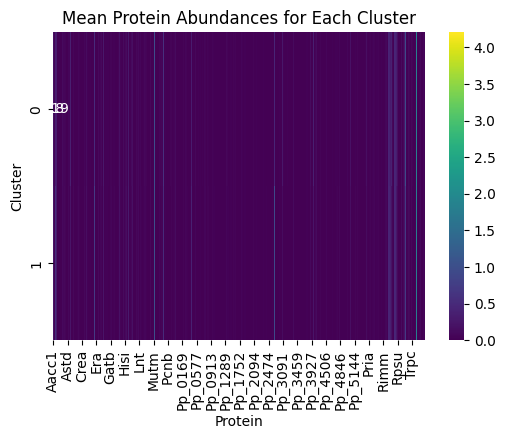

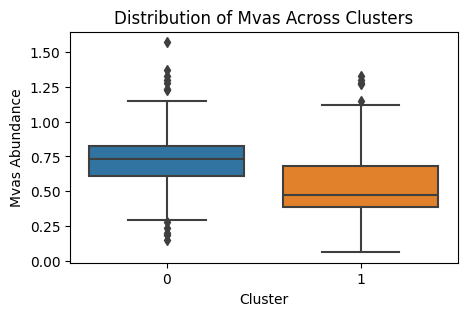

In [46]:
# Add cluster labels to the original pivot table
pivot_df['Cluster'] = cluster_labels

# Group by cluster and calculate mean protein abundance for each cluster
cluster_means = pivot_df.groupby('Cluster').mean()

# Print the mean protein abundances for each cluster
print(cluster_means)

# Plot heatmap of mean protein abundances for each cluster
plt.figure(figsize=(6, 4))
sns.heatmap(cluster_means, cmap='viridis', annot=True)
plt.title('Mean Protein Abundances for Each Cluster')
plt.xlabel('Protein')
plt.ylabel('Cluster')
plt.show()

# Compare distributions of a specific protein across clusters
protein_to_compare = 'Mvas'  # Replace with actual protein name
plt.figure(figsize=(5, 3))
sns.boxplot(data=pivot_df, x='Cluster', y=protein_to_compare)
plt.title(f'Distribution of {protein_to_compare} Across Clusters')
plt.xlabel('Cluster')
plt.ylabel(f'{protein_to_compare} Abundance')
plt.show()

In [43]:
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Assuming your DataFrames are already defined: proteomics_df and isoprenol_df

# Remove duplicate entries in "Line Name"
proteomics_df = proteomics_df.drop_duplicates(subset=['Line Name', 'Protein'])
isoprenol_df = isoprenol_df.drop_duplicates(subset='Line Name')

# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(proteomics_df, isoprenol_df, on='Line Name')

# Filter out rows where the relevant columns are zero or below the specified thresholds
filtered_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] > 0) &
                        (merged_df['isoprenol'] > 0) &
                        (merged_df['%_of protein_abundance_Top3-method'] >= 0.0001) &  # Lower threshold
                        (merged_df['isoprenol'] >= 1)]  # Lower threshold

# Pivot the DataFrame to have proteins as columns and samples as rows
pivot_df = filtered_df.pivot(index='Line Name', columns='Protein', values='%_of protein_abundance_Top3-method')

# Fill missing values with 0 or another appropriate value
pivot_df = pivot_df.fillna(0)

# Calculate Spearman's correlation coefficient for each protein with respect to isoprenol levels
correlations = {}
for protein in pivot_df.columns:
    corr, _ = spearmanr(pivot_df[protein], isoprenol_df.set_index('Line Name').loc[pivot_df.index, 'isoprenol'])
    correlations[protein] = corr

# Convert correlations to a DataFrame
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Spearman Correlation'])

# Print correlations
print(correlation_df)

       Spearman Correlation
Aacc1             -0.188083
Aapj              -0.143542
Aapm              -0.139565
Aapp               0.099111
Aapq               0.151955
...                     ...
Yidc              -0.080411
Zape               0.136260
Zipa               0.447741
Zwf-1             -0.014839
Zwf-3              0.222128

[2049 rows x 1 columns]


       Spearman Correlation  Cluster
Aacc1             -0.188083        3
Aapj              -0.143542        3
Aapm              -0.139565        3
Aapp               0.099111        2
Aapq               0.151955        2
...                     ...      ...
Yidc              -0.080411        3
Zape               0.136260        2
Zipa               0.447741        0
Zwf-1             -0.014839        2
Zwf-3              0.222128        0

[2049 rows x 2 columns]


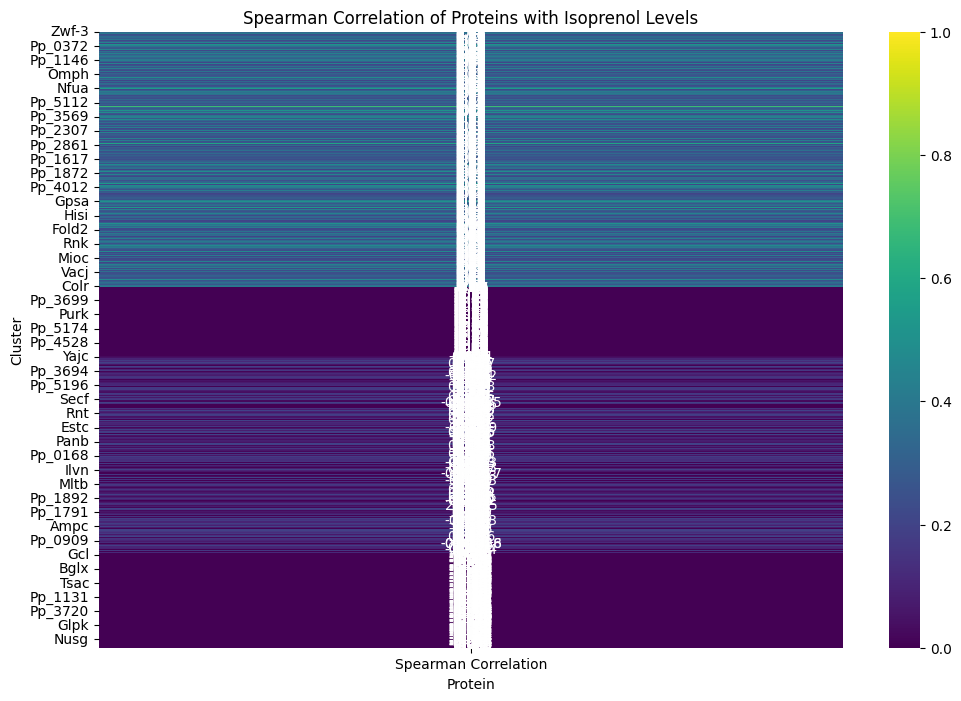

In [44]:
# Standardize the correlation data (mean=0, variance=1)
scaler = StandardScaler()
scaled_correlations = scaler.fit_transform(correlation_df)

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=4)  # You can choose the number of clusters
cluster_labels = clustering.fit_predict(scaled_correlations)

# Add cluster labels to the correlation DataFrame
correlation_df['Cluster'] = cluster_labels

# Print the cluster labels
print(correlation_df)

# Sort the correlation DataFrame by cluster labels for better visualization
sorted_correlation_df = correlation_df.sort_values('Cluster')

# Plot heatmap of Spearman correlations without cluster labels
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_correlation_df[['Spearman Correlation']], cmap='viridis', annot=True, vmin=0, vmax=1)
plt.title('Spearman Correlation of Proteins with Isoprenol Levels')
plt.xlabel('Protein')
plt.ylabel('Cluster')
plt.show()